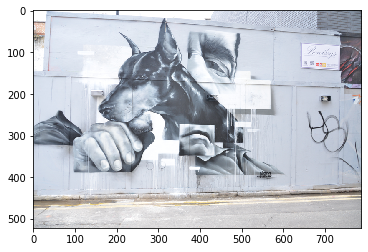

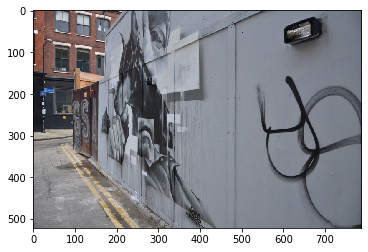

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import seaborn as sns


img1 = cv2.cvtColor(cv2.imread('img/v_dogman/1.ppm'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('img/v_dogman/6.ppm'), cv2.COLOR_BGR2RGB)
H_gt = np.loadtxt('img/v_dogman/H_1_6')
#Images are taken from HSequences dataset https://github.com/hpatches/hpatches-dataset

plt.imshow(img1)
plt.figure()
plt.imshow(img2)

device = torch.device('cuda:0')
#device = torch.device('cpu') #uncomment, if you don`t have a GPU


Lets detect and visualize SIFT features on both images

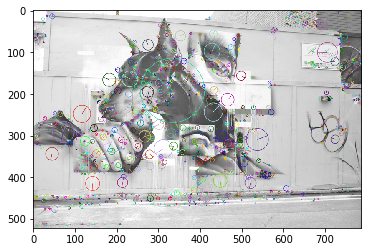

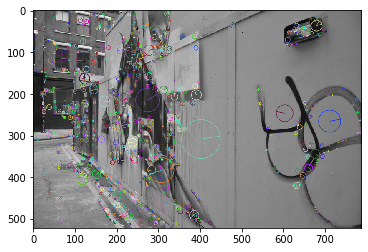

In [2]:
det = cv2.xfeatures2d.SIFT_create(3000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

vis_img1, vis_img2 = None,None
vis_img1 = cv2.drawKeypoints(cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY),kps1,vis_img1, 
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
vis_img2 = cv2.drawKeypoints(cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY),kps2,vis_img2, 
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(vis_img1)
plt.figure()
plt.imshow(vis_img2)

Now, lets implement the matching strategies 
https://medium.com/@ducha.aiki/how-to-match-to-learn-or-not-to-learn-part-2-1ab52ede2022

In [3]:
#First, function to match all descriptors to each other.
#It can be done more efficiently that this, but I am doing the vanilla way for clarity
def distance_matrix(anchor, positive):
    """Given batch of descriptors calculate distance matrix"""
    #https://github.com/DagnyT/hardnet/blob/master/code/Losses.py#L5
    d1_sq = torch.sum(anchor * anchor, dim=1).unsqueeze(-1)
    d2_sq = torch.sum(positive * positive, dim=1).unsqueeze(-1)

    eps = 1e-6
    return torch.sqrt((d1_sq.repeat(1, positive.size(0)) + torch.t(d2_sq.repeat(1, anchor.size(0)))
                      - 2.0 * torch.bmm(anchor.unsqueeze(0), torch.t(positive).unsqueeze(0)).squeeze(0))+eps)

In [4]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def ransac_and_draw_matches_cv2(kps1, kps2, tentatives, img1, img2):
    good = []
    for i in range(len(tentatives)):
        good.append(cv2.DMatch(tentatives[i,0],tentatives[i,1], 1))
    src_pts = np.float32([ kps1[m[0]].pt for m in tentatives ]).reshape(-1,1,2)
    dst_pts = np.float32([ kps2[m[1]].pt for m in tentatives ]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,1.0)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    if H is None:
        print ("No homography found")
        return
    matchesMask = mask.ravel().tolist()
    h,w,ch = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, H)
    #Ground truth transformation
    dst_GT = cv2.perspectiveTransform(pts, H_gt)
    img2_tr = cv2.polylines(decolorize(img2),[np.int32(dst)],True,(0,0,255),3, cv2.LINE_AA)
    img2_tr = cv2.polylines(deepcopy(img2_tr),[np.int32(dst_GT)],True,(0,255,0),3, cv2.LINE_AA)
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2_tr,kps2,good,None,**draw_params)
    plt.imshow(img_out)
    return

29.0 inliers found


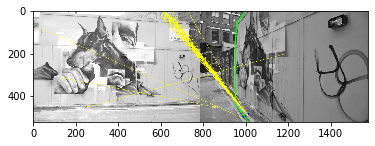

In [5]:
#Nearest neighbor matching strategy
def match_nn(desc1, desc2, dm = None):
    if dm is None:
        dm = distance_matrix(torch.from_numpy(desc1.astype(np.float32)).to(device),
                        torch.from_numpy(desc2.astype(np.float32)).to(device))
    vals, idxs_in_2 = torch.min(dm,dim=1)
    idxs_in1 = torch.arange(0, idxs_in_2.size(0))
    matches_idxs = torch.cat([idxs_in1.view(-1,1), idxs_in_2.cpu().view(-1,1)],dim=1)
    return matches_idxs.cpu().data.numpy(), dm

tentatives_nn, dm = match_nn(descs1, descs2)
dm = None
ransac_and_draw_matches_cv2(kps1, kps2, tentatives_nn, img1, img2)

You can see that we have found some matches, but they are very wrong.

6.0 inliers found


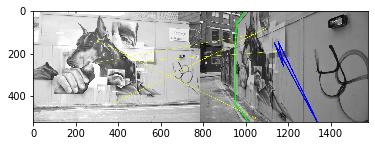

In [6]:
#Nearest neighbor matching strategy. 
def match_mutual_nn(desc1, desc2):
    matches_idxs_1to2, dm = match_nn(desc1,desc2)
    matches_idxs_2to1, dm = match_nn(desc2, desc1, dm.t())
    out = []
    for i in range(len(matches_idxs_1to2)):
        i1,i2 = matches_idxs_1to2[i]
        mask = matches_idxs_2to1[:,1]==i1
        row = matches_idxs_2to1[mask]
        if len(row)>0:
            i22, i11 = row[0]
            if (i1 == i11) and (i2==i22):
                out.append(matches_idxs_1to2[i].reshape(1,-1))
    if len(out) > 0:
        return np.concatenate(out,axis=0).astype(np.int32)
    return np.zeros((2,0)).astype(np.int32)


tentatives_mutual_nn = match_mutual_nn(descs1, descs2)
ransac_and_draw_matches_cv2(kps1, kps2, tentatives_mutual_nn, img1, img2)

Mutual NN improves things, but still very wrong. Lets check SNN

11.0 inliers found


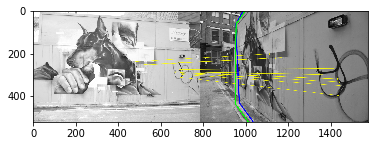

In [7]:
#Second nearest neighbor ratio matching strategy - SNN
#David Lowe.  Distinctive image features from scale-invariant keypoints. IJCV, 2004
def match_snn(desc1, desc2):
    dm = distance_matrix(torch.from_numpy(desc1.astype(np.float32)).to(device),
                        torch.from_numpy(desc2.astype(np.float32)).to(device))
    vals, idxs_in_2 = torch.topk(dm, 2 ,dim=1, largest=False)
    mask = (vals[:,0] / vals[:,1]) <= 0.8
    idxs_in1 = torch.arange(0, idxs_in_2.size(0))[mask]
    idxs_in_2 = idxs_in_2[:,0][mask]
    matches_idxs = torch.cat([idxs_in1.view(-1,1), idxs_in_2.cpu().view(-1,1)],dim=1)
    return matches_idxs.cpu().data.numpy()


tentatives_snn = match_snn(descs1, descs2)
ransac_and_draw_matches_cv2(kps1, kps2, tentatives_snn, img1, img2)


Good job! But not yet ideal. Lets try FGINN

15.0 inliers found


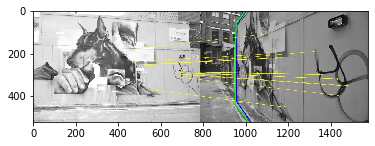

In [8]:
#1st geometricall inconsistent nearest neighbor ratio matching strategy - FGINN
# D. Mishkin, J. Matas, M. Perdoch. MODS: Fast and Robust Method for Two-View Matching. CVIU 2015
def match_fginn(desc1, desc2, kps1, kps2):
    xy1 = np.concatenate([np.array(p.pt).reshape(1,2) for p in kps1],axis = 0)
    xy2 = np.concatenate([np.array(p.pt).reshape(1,2) for p in kps2],axis = 0)

    dm = distance_matrix(torch.from_numpy(desc1.astype(np.float32)).to(device),
                        torch.from_numpy(desc2.astype(np.float32)).to(device))
    vals, idxs_in_2 = torch.min(dm,dim=1)
    #xy2, xy2 is not a typo below, because we need to have a distance between 
    #keypoint in the same image
    km = distance_matrix(torch.from_numpy(xy2.astype(np.float32)).cuda(),
                         torch.from_numpy(xy2.astype(np.float32)).cuda())
    mask1 = km <= 10.0
    mask2 = mask1[idxs_in_2,:]
    dm[mask2] = 100000# some big number to mask out
    vals_2nd, idxs_in_2_2nd = torch.min(dm,dim=1)
    ratio = vals / vals_2nd
    mask = ratio <= 0.8
    idxs_in_1 = torch.arange(0, idxs_in_2.size(0))[mask]
    idxs_in_2 = idxs_in_2[mask]
    matches_idxs = torch.cat([idxs_in_1.view(-1,1), idxs_in_2.cpu().view(-1,1)],dim=1)
    return matches_idxs.cpu().data.numpy()


tentatives_fginn = match_fginn(descs1, descs2, kps1, kps2)
ransac_and_draw_matches_cv2(kps1, kps2, tentatives_fginn, img1, img2)


Closer! Lets re-factor FGINN a bit.

15.0 inliers found


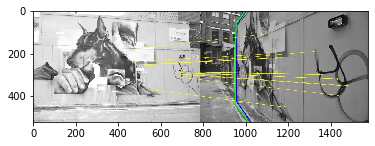

In [9]:
#Now, lets refactor FGINN into two functions:
def get_fginn_indexes(dm,km,th=0.8):
    vals, idxs_in_2 = torch.min(dm,dim=1)
    mask1 = km <= 10.0
    mask2 = mask1[idxs_in_2,:]
    dm[mask2] = 100000# = 100000
    vals_2nd, idxs_in_2_2nd = torch.min(dm,dim=1)
    ratio = vals / vals_2nd
    mask =ratio <= 0.8
    idxs_in_1 = torch.arange(0, idxs_in_2.size(0))[mask]
    idxs_in_2 = idxs_in_2[mask]
    ml = torch.cat([idxs_in_1.view(-1,1).cpu(), idxs_in_2.cpu().view(-1,1)],dim=1)
    return ml
def match_fginn(desc1, desc2, kps1, kps2):
    xy1 = np.concatenate([np.array(p.pt).reshape(1,2) for p in kps1],axis = 0)
    xy2 = np.concatenate([np.array(p.pt).reshape(1,2) for p in kps2],axis = 0)

    dm = distance_matrix(torch.from_numpy(desc1.astype(np.float32)).to(device),
                        torch.from_numpy(desc2.astype(np.float32)).to(device))
    km = distance_matrix(torch.from_numpy(xy2.astype(np.float32)).cuda(),
                         torch.from_numpy(xy2.astype(np.float32)).cuda())
    return get_fginn_indexes(dm,km, 0.8)

tentatives_fginn = match_fginn(descs1, descs2, kps1, kps2)
ransac_and_draw_matches_cv2(kps1, kps2, tentatives_fginn, img1, img2)


Same results, good. Lets for symmetric FGINNs

37.0 inliers found


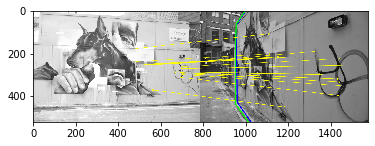

In [10]:
#Symmetric FGINN union. Combination of 
# D. Mishkin, J. Matas, M. Perdoch. MODS: Fast and Robust Method for Two-View Matching. CVIU 2015
# and 
# F. Bellavia and C. Colombo. Which is Which? Evaluation of local descriptors 
# for image matching in real-world scenarios. 2019
def match_sym_fginn_union(desc1, desc2, kps1, kps2):
    xy1 = np.concatenate([np.array(p.pt).reshape(1,2) for p in kps1],axis = 0)
    xy2 = np.concatenate([np.array(p.pt).reshape(1,2) for p in kps2],axis = 0)

    dm = distance_matrix(torch.from_numpy(desc1.astype(np.float32)).to(device),
                        torch.from_numpy(desc2.astype(np.float32)).to(device))
    km1 = distance_matrix(torch.from_numpy(xy2.astype(np.float32)).cuda(),
                         torch.from_numpy(xy2.astype(np.float32)).cuda())
    km2 = distance_matrix(torch.from_numpy(xy1.astype(np.float32)).cuda(),
                         torch.from_numpy(xy1.astype(np.float32)).cuda())
    m1 = get_fginn_indexes(dm.clone(), km1).data.cpu().numpy()
    m2 = get_fginn_indexes(dm.t(), km2).data.cpu().numpy()[:,::-1]
    return np.concatenate([m1,m2],axis=0)


tentatives_fginn_sym_union = match_sym_fginn_union(descs1, descs2, kps1, kps2)
ransac_and_draw_matches_cv2(kps1, kps2, tentatives_fginn_sym_union, img1, img2)


11.0 inliers found


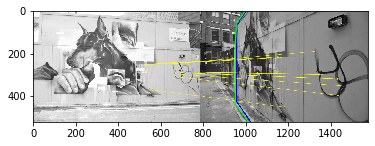

In [11]:
#Symmetric FGINN intersection . Combination of 
# D. Mishkin, J. Matas, M. Perdoch. MODS: Fast and Robust Method for Two-View Matching. CVIU 2015
# and 
# F. Bellavia and C. Colombo. Which is Which? Evaluation of local descriptors 
# for image matching in real-world scenarios. 2019

def match_sym_fginn_intersection(desc1, desc2, kps1, kps2):
    xy1 = np.concatenate([np.array(p.pt).reshape(1,2) for p in kps1],axis = 0)
    xy2 = np.concatenate([np.array(p.pt).reshape(1,2) for p in kps2],axis = 0)

    dm = distance_matrix(torch.from_numpy(desc1.astype(np.float32)).to(device),
                        torch.from_numpy(desc2.astype(np.float32)).to(device))
    km1 = distance_matrix(torch.from_numpy(xy2.astype(np.float32)).cuda(),
                         torch.from_numpy(xy2.astype(np.float32)).cuda())
    km2 = distance_matrix(torch.from_numpy(xy1.astype(np.float32)).cuda(),
                         torch.from_numpy(xy1.astype(np.float32)).cuda())
    m1 = get_fginn_indexes(dm.clone(), km1).data.cpu().numpy()
    m2 = get_fginn_indexes(dm.t(), km2).data.cpu().numpy()[:,::-1]
    out_m = []
    for i in range(len(m1)):
        i1,i2 = m1[i]
        mask = m2[:,0]==i1
        row = m2[mask]
        if len(row)>0:
            i11, i22 = row[0]
            if (i1 == i11) and (i2==i22):
                out_m.append(m1[i].reshape(1,-1))
    if len(out_m) > 0:
        return np.concatenate(out_m,axis=0).astype(np.int32)
    return np.zeros((2,0)).astype(np.int32)


tentatives_fginn_sym_inter = match_sym_fginn_intersection(descs1, descs2, kps1, kps2)
ransac_and_draw_matches_cv2(kps1, kps2, tentatives_fginn_sym_inter, img1, img2)
